# Task 3 - Confounders in the Context of Artitficial Intelligence

## Example
### Scenario
The goal is to develop a ML model that predicts muscle mass, based on exercise level and calorie intake. Unfortunately exercise level is a confounder and calorie intake has no true causal impact on muscle mass. 

### Steps
1. Define DAG
2. Create sample data based on DAG relationships
3. Visualize data
4. Perform initial regression analysis (simple and multiple)
5. Use PSM to make data comparable
6. Fit new regression models on PSM dataset
7. Use DoWhy to identify confounders

### Variables
* exercise level: 
    randomly created, categorical, 1-10
* calorie intake: 
    exercise level influences, binary, 0: low calorie intake 1: high calorie intake
* muscle mass: 
    exercise level influences, continous, 50 - 92%

### Basic Formulas
1. Propensity Score Formula:
* e(X) = P( T=1 | X)
* e(X): propensity score, T: Treament indicator (1 or 0), X: Covariates
2. Adjustment Formula
* Y^(0) = 1/N ∑ i=1 to N (TiYi / e(Xi))
* Y^(0): expected outcome untreated, N: number of subjects total, Ti: Treatment indicator for subject, Yi: Outcome indicator for subject, e(Xi): Propensity score for subject
* Y^(1) = 1/N ∑ i=1 to N ((1-Ti)Yi / (1-e(Xi)))
* Y^(1): expected outcome for treated

In [581]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, r2_score
from sklearn.neighbors import NearestNeighbors
from dowhy import CausalModel

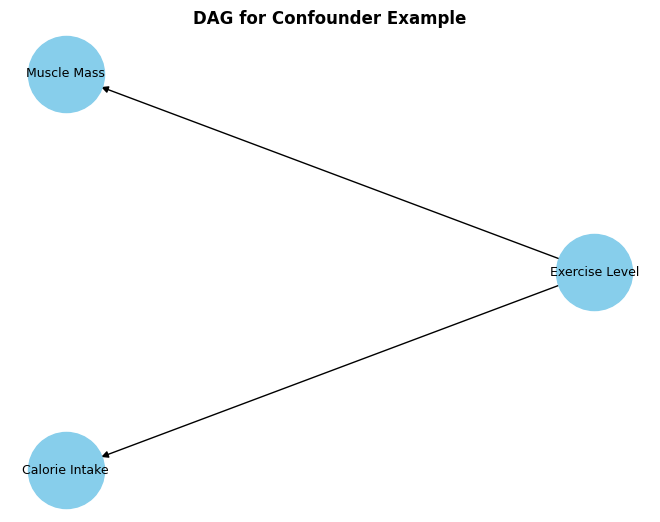

In [597]:
# Draw a Directed Acyclic Graph (DAG) for the confounder example
dag = nx.DiGraph()
dag.add_edges_from([("Exercise Level", "Muscle Mass"), ("Exercise Level", "Calorie Intake")])

pos = nx.circular_layout(dag)
nx.draw(dag, pos, with_labels=True, node_size=3000, node_color='skyblue', linewidths=1, font_size=9)
plt.title('DAG for Confounder Example', fontweight='bold')
plt.show()

In [583]:
# Data generation
np.random.seed(73)
datasize = 1000

exercise_level = np.random.randint(1, 11, datasize) # rated from 1 to 10
muscle_mass = 0.42 + exercise_level * 0.05 + np.random.normal(0, 0.01, datasize) # higher exercise level leads to higher muscle mass (50% to 92% of body weight)
muscle_mass = np.clip(muscle_mass, 0.5, 0.92)
prob_high_calorie = exercise_level / 10.0  # higher exercise level means higher probability of high calorie intake
random_noise = np.random.normal(0, 0.2, datasize)  # added noise
calorie_intake_prob = prob_high_calorie + random_noise
calorie_intake = (calorie_intake_prob > 0.5).astype(int)  # binary high (1) or low (0) calorie intake

data = pd.DataFrame({'exercise_level': exercise_level, 'muscle_mass': muscle_mass, 'calorie_intake': calorie_intake})
data.head()

,exercise_level,muscle_mass,calorie_intake
0,7,0.772909,1
1,3,0.568684,0
2,1,0.500000,0
3,9,0.864113,1
4,4,0.595838,0


In [584]:
def visualize_data(data):
    plt.figure(figsize=(10, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=data, x='calorie_intake', y='muscle_mass', color='blue')
    plt.xlabel('Calorie Intake(0: Low, 1: High)')
    plt.ylabel('Muscle Mass(%)')
    plt.title('Calorie Intake vs Muscle Mass', fontweight='bold')

    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, x='exercise_level', y='muscle_mass', color='blue')
    plt.xlabel('Exercise Level')
    plt.ylabel('Muscle Mass(%)')
    plt.title('Exercise Level vs Muscle Mass', fontweight='bold')

    plt.tight_layout()
    plt.show()

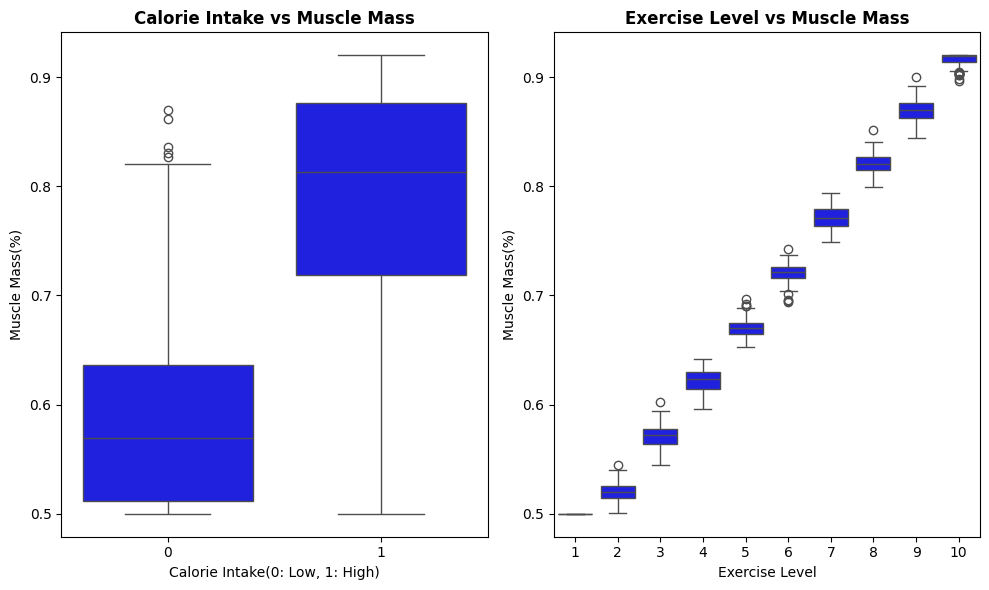

In [585]:
visualize_data(data)

### Interpretationof visualization part 1
The data shows significant differences in muscle mass between calorie intake groups, this can be an indicator of a confounding effect. 
The clear trend in muscle mass with exercise levels indicates that this variable should be controlled for. Which makes sense as it is the confounder in this example.

In [586]:
data_model_1 = data.copy()
data_model_2 = data.copy()
data_model_3 = data.copy()
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(data_model_1[['exercise_level']], data_model_1['muscle_mass'], test_size=0.2, random_state=73)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(data_model_2[['calorie_intake']], data_model_2['muscle_mass'], test_size=0.2, random_state=73)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(data_model_3[['exercise_level', 'calorie_intake']], data_model_3['muscle_mass'], test_size=0.2, random_state=73)

In [587]:
# Linear regression model
def linear_regression(X_train, X_test, y_train, y_test, independent_vars):
    # Train the model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Make predictions
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # Calculate R^2 scores
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    
    # Print results
    print("Independent Variables:", independent_vars)
    print("Coefficient:", model.coef_)
    print("Intercept:", model.intercept_)
    print("R^2 for training set:", r2_train)
    print("R^2 for testing set:", r2_test)

In [588]:
# Linear regression model 1: exercise level only
linear_regression(X_train_1, X_test_1, y_train_1, y_test_1, ['Exercise Level'])

Independent Variables: ['Exercise Level']
Coefficient: [0.04814995]
Intercept: 0.43336727633530786
R^2 for training set: 0.993379370701742
R^2 for testing set: 0.9930490980218919


In [589]:
# Linear regression model 2: calorie intake only
linear_regression(X_train_2, X_test_2, y_train_2, y_test_2, ['Calorie Intake'])

Independent Variables: ['Calorie Intake']
Coefficient: [0.20570069]
Intercept: 0.5867046450797717
R^2 for training set: 0.523753028986431
R^2 for testing set: 0.4991086727016383


In [590]:
# Linear regression model 3: calorie intake and exercise level (Mulitiple Regression)
linear_regression(X_train_3, X_test_3, y_train_3, y_test_3, ['Exercise Level', 'Calorie Intake'])


Independent Variables: ['Exercise Level', 'Calorie Intake']
Coefficient: [ 0.04823324 -0.00067386]
Intercept: 0.4332880651661702
R^2 for training set: 0.993382018795108
R^2 for testing set: 0.9930249213979788


### Interpretation of Results part 1
Only having calorie intake as an independent variable shows the worst performance on the training and test data. However there is still some predictive power left, which is due to the confounding effect of exercise level, which was not controlled for in this example. 
The multiple regression model performs really well, it compensates for the presence of calorie intake as an extra variable by assigning it a lower coefficient and a higher coefficient to exercise level as when just regrssing with exercise level as the independent variable. It seems to be able to adjust for the confounding effect as long as the confounding variable is included. 


#### Propensity Score Matching
Using a more sophisticated method like PPM can help reduce bias. It tries to mimic randomization by creating comparable groups based on observed characteristics. 

In [591]:
def propensity_score_matching_analysis(df, treatment_var, outcome_var, confounders):
    """
    Perform propensity score matching and analyze the effect of a binary treatment on an outcome.

    Parameters:
    data (pd.DataFrame): The input data containing the treatment, outcome, and confounders.
    treatment_var (str): The binary treatment variable name.
    outcome_var (str): The outcome variable name.
    confounders (list): List of confounder variable names.
    category (str): Select either high or low calorie intake as the treatment.

    Returns:
    dict: A dictionary containing the coefficients, intercept, and R-squared value of the model.
    """

    data = df.copy()
    data['treatment'] = data[treatment_var]
    

     # Step 2: Calculate propensity scores using logistic regression
    X_prop = data[confounders]
    y_prop = data['treatment']
    propensity_model = LogisticRegression()
    propensity_model.fit(X_prop, y_prop)
    data['propensity_score'] = propensity_model.predict_proba(X_prop)[:, 1]

    # Perform nearest neighbor matching
    treated = data[data['treatment'] == 1]
    control = data[data['treatment'] == 0]
    
    nn = NearestNeighbors(n_neighbors=1)
    nn.fit(control[['propensity_score']])
    
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    matched_control = control.iloc[indices.flatten()]
    
    matched_data = pd.concat([treated.reset_index(drop=True), matched_control.reset_index(drop=True)], axis=0)

    X_train, X_test, y_train, y_test = train_test_split(matched_data[['treatment']], matched_data[outcome_var], test_size=0.2, random_state=73)

    # Analyze the effect of calorie intake on muscle mass in matched groups

    model_matched = LinearRegression().fit(X_train, y_train)
    preds_matched_train = model_matched.predict(X_train)
    preds_matched_test = model_matched.predict(X_test)
    r2_matched_train = r2_score(y_train, preds_matched_train)
    r2_matched_test = r2_score(y_test, preds_matched_test)

    result_simple = {
        'coefficient': model_matched.coef_,
        'intercept': model_matched.intercept_,
        'r2_train': r2_matched_train,
        'r2_test': r2_matched_test,
    }   

    X_train_multiple, X_test_multiple, y_train_multiple, y_test_multiple = train_test_split(matched_data[['exercise_level', 'treatment']], matched_data[outcome_var], test_size=0.2, random_state=73)

    # Analyze the effect of calorie intake on muscle mass in matched groups
    model_matched_multiple = LinearRegression().fit(X_train_multiple, y_train_multiple)
    preds_matched_multiple_train = model_matched_multiple.predict(X_train_multiple)
    preds_matched_multiple_test = model_matched_multiple.predict(X_test_multiple)
    r2_matched_multiple_train = r2_score(y_train_multiple, preds_matched_multiple_train)
    r2_matched_multiple_test = r2_score(y_test_multiple, preds_matched_multiple_test)

    result_with_confounders = {
        'coefficient': model_matched_multiple.coef_,
        'intercept': model_matched_multiple.intercept_,
        'r2_train': r2_matched_multiple_train,
        'r2_test': r2_matched_multiple_test
    }

    return result_simple, result_with_confounders, matched_data


In [592]:
result_simple, result_with_confounders, matched_data = propensity_score_matching_analysis(data, 'calorie_intake', 'muscle_mass', ['exercise_level'])

print("Simple Model (Calorie Intake Only):")
print("Coefficient:", result_simple['coefficient'])
print("Intercept:", result_simple['intercept'])
print("R^2_Train:", result_simple['r2_train'])
print("R^2_Test", result_simple['r2_test'])
print("--------------------")
print("Model with Confounders (Exercise Level + Calorie Intake):")
print("Coefficient:", result_with_confounders['coefficient'])
print("Intercept:", result_with_confounders['intercept'])
print("R^2_Train:", result_with_confounders['r2_train'])
print("R^2_Test", result_with_confounders['r2_test'])

Simple Model (Calorie Intake Only):
Coefficient: [0.00802699]
Intercept: 0.7772463832759962
R^2_Train: 0.001574696892217009
R^2_Test -0.017802246923237952
--------------------
Model with Confounders (Exercise Level + Calorie Intake):
Coefficient: [0.0497831 0.0026533]
Intercept: 0.41872164030281434
R^2_Train: 0.9899775208616872
R^2_Test 0.9905624010532631


### Interpretation of Results part 2
When using data that has been matched by PSM before it is even more apparent that calorie intake has no impact on the results, as its predictive power is about zero or below zero for test and training accuracy.

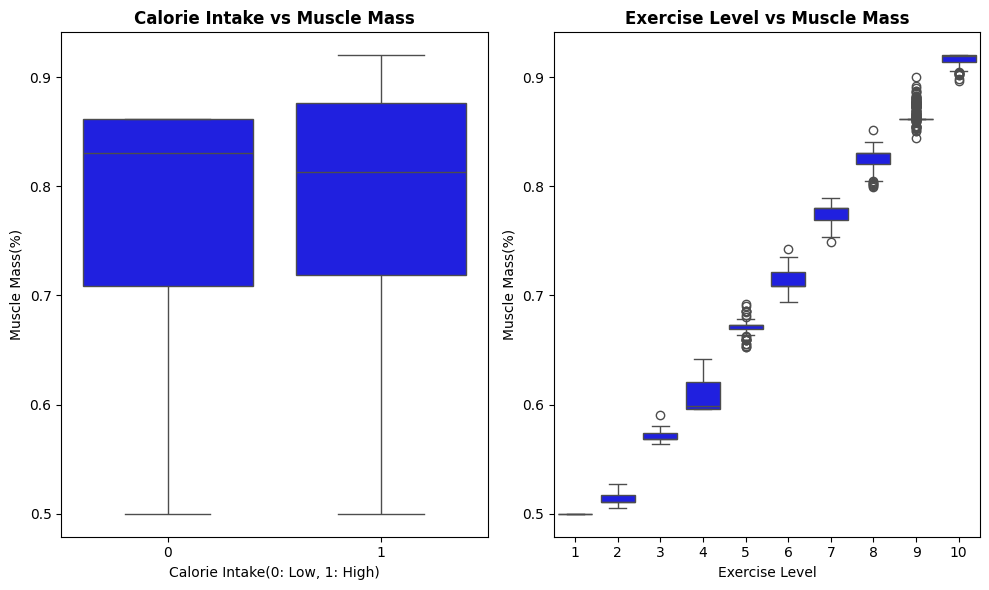

In [593]:
visualize_data(matched_data)

### Interpretaion of visualization part 2
The distributions are now much more similar for calorie intake, while the trend for exercise level remains. Suggesting that the confounding effect has successfully been removed. 

#### Causal approach DoWhy
Another way to approach identifying possible confounders is using the dowhy package.  

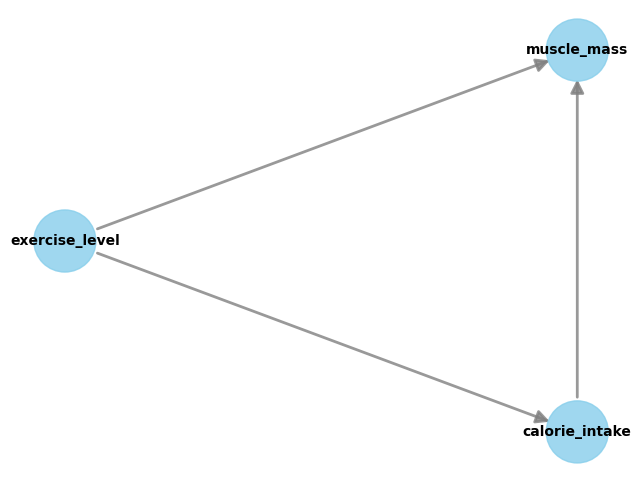

Causal Estimate is -1.925037296002241e-05
Refute: Add a random common cause
Estimated effect:-1.925037296002241e-05
New effect:-1.721092804383373e-05
p value:1.0



In [594]:
# DoWhy approach to Confounder Example
model_do_why = CausalModel(
    data=data,
    treatment='calorie_intake',
    outcome='muscle_mass',
    common_causes=['exercise_level'],
    instruments=None
)

model_do_why.view_model()

identified_estimand = model_do_why.identify_effect()
estimate = model_do_why.estimate_effect(identified_estimand, method_name='backdoor.linear_regression')

print(f"Causal Estimate is {estimate.value}")

refute_results = model_do_why.refute_estimate(identified_estimand, estimate, method_name='random_common_cause')
print(refute_results)

### Interpretation of Results part 3
DoWhy estimates a minimal causal influence of calorie intake on muscles mass, with a high p-value for teh refutation test. This is a really amazing result as it perfectly aligns with our data generation. The only variable that actually influences muscle mass is the exercise level, the DoWhy library realizes that and provides a pretty good (in this case extremly low) estimate.

### Example used in Advanced Workbook

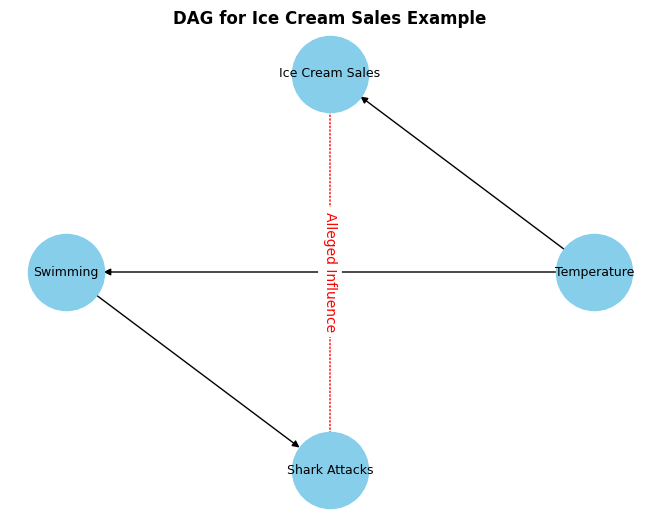

In [598]:
# Draw a Directed Acyclic Graph (DAG) for the ice cream sales example
dag_2 = nx.DiGraph()
dag_2.add_edges_from([("Temperature", "Ice Cream Sales"), ("Temperature", "Swimming"), ("Swimming", "Shark Attacks")])

pos = nx.circular_layout(dag_2)
nx.draw(dag_2, pos, with_labels=True, node_size=3000, node_color='skyblue', linewidths=1, font_size=9)
nx.draw_networkx_edges(dag_2, pos, edgelist=[("Ice Cream Sales", "Shark Attacks")], style="dotted", edge_color='r')
nx.draw_networkx_edge_labels(dag_2, pos, edge_labels={("Ice Cream Sales", "Shark Attacks"): 'Alleged Influence'}, font_color='red')

plt.title('DAG for Ice Cream Sales Example', fontweight='bold')
plt.show()